# Análise de sobreviventes do Titanic
O dataset de sobrevivents do Titanic é bastante usado como exemplo didático para ilustrar conceitos de tratamento e exploração de dados.

Vamos começar importando dados para um pandas DataFrame a partir de um arquivo CSV:

In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('datasets/titanic.csv')
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


A informação acima mostra que esse dataset contém informações sobre 891 passageiros: seus nome, gênero, idade, etc (para uma descrição completa do significado de cada coluna, confira [este link](https://www.kaggle.com/c/titanic/data)).

## Valores em branco
Antes de iniciar a análise em si, precisamos checar como está a "saúde" dos dados verificando quanta informação está presente de fato em cada coluna.

In [4]:
# POrcentagem de valores em branco em cada coluna
(raw_data.isnull().sum() / len(raw_data)) * 100.0

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

Pode-se ver que 77% dos passageiros não apresentam informação sobre em qual cabine eles estavam alojados. Essa informação pode ser útil para análise posterior mas, por enquanto, vamos descartar essa coluna:

In [5]:
raw_data.drop('Cabin', axis='columns', inplace=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


A coluna *Embarked*, que informa em qual porto o passageiro embarcou, possui apenas algumas poucas linhas em branoc. Como a quantidade de passageiros sem essa informação é pequena, é razoável assumir que eles podem ser descartados do dataset sem grandes prejuízos:

In [6]:
raw_data.dropna(subset=['Embarked'], inplace=True)
(raw_data.isnull().sum() / len(raw_data)) * 100.0

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.910011
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Embarked        0.000000
dtype: float64

Finalmente, cerca de 20% dos passageiros não possuem informação de idade. Não parece razoável exluir todos eles e tampouco descartar a coluna inteira, então uma solução possível é preenchermos os valores em branco dessa coluna com o valor mediano dela no dataset:

In [7]:
raw_data.fillna({'Age': raw_data.Age.median()}, inplace=True)
(raw_data.isnull().sum() / len(raw_data)) * 100.0

PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
dtype: float64

### Por que usar a mediana ao invés da média?
A mediana representa uma *estatística robusta*. Uma *estatística* é um número que resume um conjunto de valores, enquanto que uma estatística é considerada *robusta* se ela não for afetada significativamente por variações nos dados.

Suponha, por exemplo, que temos um grupo de pessoas cujas idades sejam [15, 16, 14, 15, 15, 19, 14, 17]. A média de idades nesse grupo é de 15.625. Se uma pessoa de 80 anos for adicionada a esse grupo, a média de idades será agora 22.77, o que não parece representar bem o perfil de idades prevalente desse grupo.
A mediana nesses dois exemplos, por sua vez, é de 15 anos - isto é, o valor da mediana não é afetado pela presença de um *outlier* nos dados, o que a torna uma estatística robusta para as idades desse grupo.

Agora que todas as informações sobre os passageiros no conjunto de dados foram "limpas", podemos começar a analisar os dados.

## Análise exploratória

Vamos começar explorando quantas pessoas nesse dataset sobreviveram ao Titanic:

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

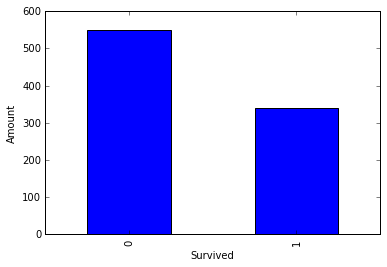

In [9]:
overall_fig = raw_data.Survived.value_counts().plot(kind='bar')
overall_fig.set_xlabel('Survived')
overall_fig.set_ylabel('Amount')

No geral, 38% dos passageiros sobreviveram.

Vamos agora segmentar a proporção de pessoas que sobreviveram ao longo de diferentes recortes (o código usado para gerar os gráficos abaixo foram retirados [desse link](http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html)).

### Recorte de gênero

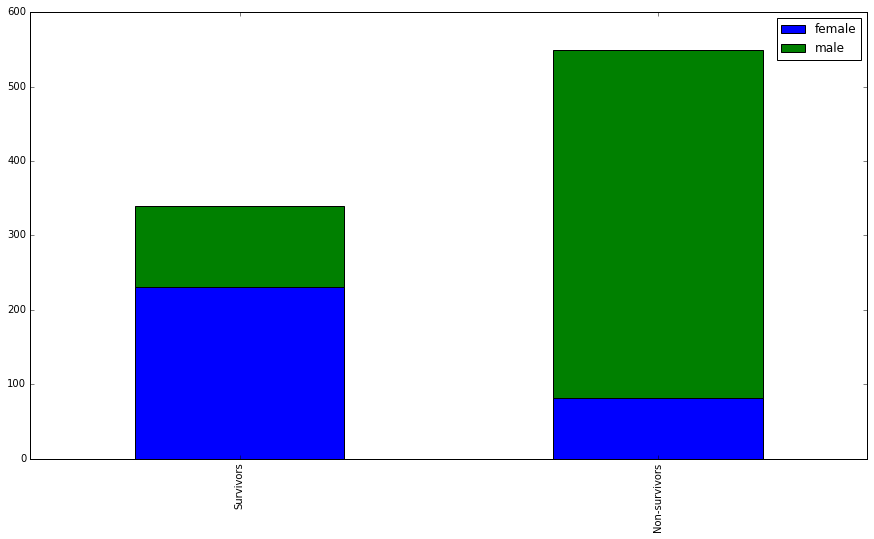

In [10]:
survived_sex = raw_data[raw_data['Survived']==1]['Sex'].value_counts()
dead_sex = raw_data[raw_data['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived_sex,dead_sex])
df.index = ['Survivors','Non-survivors']
df.plot(kind='bar',stacked=True, figsize=(15,8));

### Recorte de idade

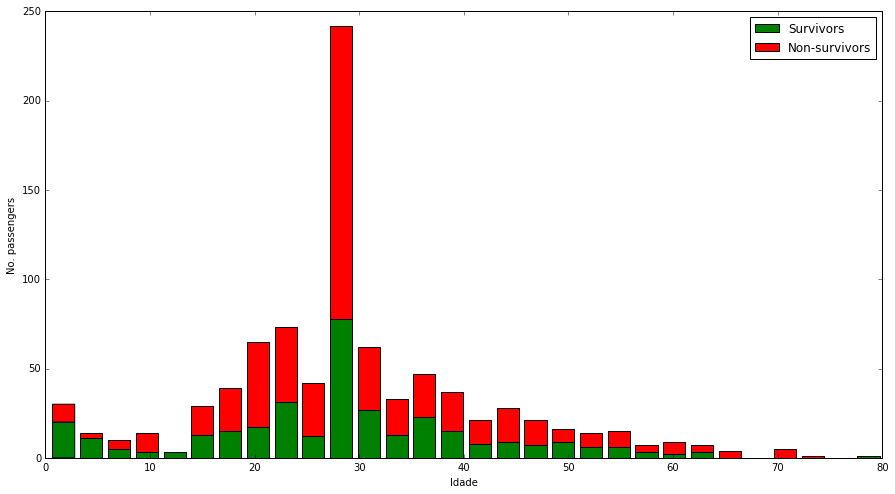

In [11]:
figure = plt.figure(figsize=(15,8))
plt.hist([raw_data[raw_data['Survived']==1]['Age'], raw_data[raw_data['Survived']==0]['Age']], 
         stacked=True, color=['g','r'],
         bins=30, label=['Survivors','Non-survivors'])
plt.xlabel('Idade')
plt.ylabel('No. passengers')
plt.legend();

### Por preço de passagem

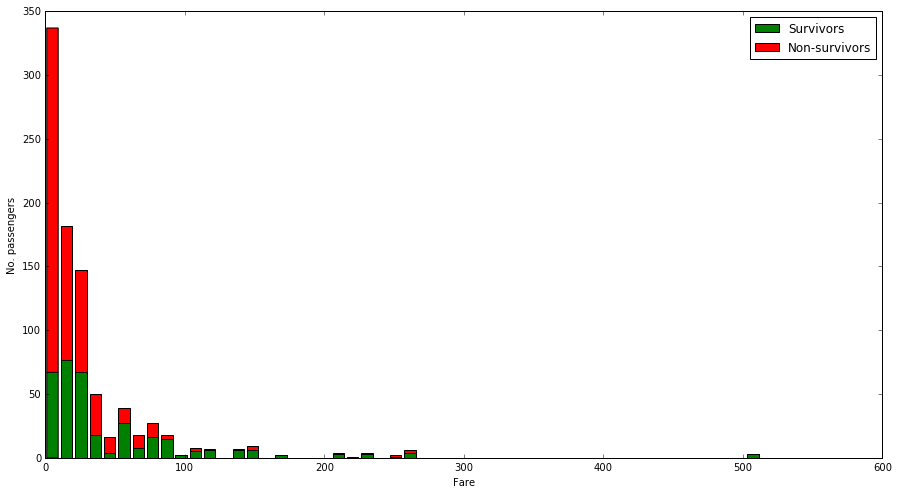

In [12]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(15,8))
plt.hist([raw_data[raw_data['Survived']==1]['Fare'], raw_data[raw_data['Survived']==0]['Fare']], 
         stacked=True, color=['g','r'],
         bins=50, label=['Survivors','Non-survivors'])
plt.xlabel('Fare')
plt.ylabel('No. passengers')
plt.legend();

Os gráficos acima indicam que passageiros que sejam do gênero feminino, com menos de 20 anos de idade e que pagaram passsagens mais caras tiveram uma maior chance de ter sobrevivido.

Como podemos usar essa informação para tentar prever se um passageiro qualquer teria sobrevivido ao acidente?

## Previsão das chances de sobrevivência

Iniciemos então mantendo apenas a informação que queremos utilizar - os nomes de passageiros também serão mantidos para análise posterior:

In [13]:
data_for_prediction = raw_data[['Name', 'Sex', 'Age', 'Fare', 'Survived']]
data_for_prediction.is_copy = False
data_for_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 5 columns):
Name        889 non-null object
Sex         889 non-null object
Age         889 non-null float64
Fare        889 non-null float64
Survived    889 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 41.7+ KB


### Codificação numérica de Strings
Algumas informaçõe estão codificadas como strings: a informação sobre o gênero do passageiro, por exemplo, é representada pelas strings **male** e **female**. Para usar essa informação no nosso futuro modelo preditivo, devemos converter esses valores para um formato numérico:

In [14]:
data_for_prediction['Sex'] = data_for_prediction.Sex.map({'male': 0, 'female': 1})
data_for_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 5 columns):
Name        889 non-null object
Sex         889 non-null int64
Age         889 non-null float64
Fare        889 non-null float64
Survived    889 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 41.7+ KB


### Divisão entre treinamento e teste

Para poder avaliar a capacidade preditiva do modelo, uma parte dos dados (nesse caso, 25%) deve ser separada para um *conjunto de teste*.

Um conjunto de teste é um dataset para o qual os valores a serem previstos são conhecidos mas que não são usados para treinar o modelo, sendo portanto usados para avaliar quantos acertos o modelo consegue fazer em um conjunto de exemplos que ele nunca viu durante o treinamento. Isso permite que avaliemos, de maneira não-enviesada, o quanto o modelo deve acertar ao ser aplicado a dados reais.

In [15]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data_for_prediction, test_size=0.25, random_state=254)
len(train_data), len(test_data)

(666, 223)

### Previsão de chances de sobrevivência usando árvores de decisão

Usaremos um simples modelo de Árvore de Decisão para prever se um passageiro teria sobrevivido ao Titanic usando seu gênero, idade e preço de passagem.

In [16]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(train_data[['Sex', 'Age', 'Fare']], train_data.Survived)
tree.score(test_data[['Sex', 'Age', 'Fare']], test_data.Survived)

0.80269058295964124

Com uma simples árvore de decisão, o resultado cima indica que seria possível prever corretamente a sobrevivência de cerca de 80% dos passageiros.

Um exercício interessante de se fazer após treinar um modelo é dar uma olhada nos casos em que ele erra:

In [17]:
test_data.is_copy = False
test_data['Predicted'] = tree.predict(test_data[['Sex', 'Age', 'Fare']])
test_data[test_data.Predicted != test_data.Survived]

,Name,Sex,Age,Fare,Survived,Predicted
207,"Albimona, Mr. Nassef Cassem",0,26.00,18.7875,1,0
660,"Frauenthal, Dr. Henry William",0,50.00,133.6500,1,0
81,"Sheerlinck, Mr. Jan Baptist",0,29.00,9.5000,1,0
762,"Barah, Mr. Hanna Assi",0,20.00,7.2292,1,0
446,"Mellinger, Miss. Madeleine Violet",1,13.00,19.5000,1,0
247,"Hamalainen, Mrs. William (Anna)",1,24.00,14.5000,1,0
43,"Laroche, Miss. Simonne Marie Anne Andree",1,3.00,41.5792,1,0
137,"Futrelle, Mr. Jacques Heath",0,37.00,53.1000,0,1
679,"Cardeza, Mr. Thomas Drake Martinez",0,36.00,512.3292,1,0
821,"Lulic, Mr. Nikola",0,27.00,8.6625,1,0


Um exemplo de previsão incorreta acima é o caso da passageira **Mrs. Hudson J C Allison**, que não sobreviveu ao acidente do Titanic apesar de ser uma mulher de 25 anos que pagou uma passagem cara. Uma busca na [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-victim/bessie-waldo-allison.html) mostra que ela foi informada, após já ter sido alocada em um bote salva-vidas, que seu filho seria embarcado em um outro bote que estava no lado oposto do navio - ela, então, fugiu do seu próprio bote em uma tentativa de se juntar a seu filho mas não obteve êxito.

Uma coleção de histórias particularmente interesantes relacionadas a passageiros do Titanic pode ser encontrada [nesse post](https://blog.socialcops.com/engineering/machine-learning-python/).